## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

### Задание 1
Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os
import statsmodels.api as sm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_energy_resampled_weeks = data.resample("W").mean()
data_energy_resampled_weeks.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


### Задание 2
Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков

In [4]:
# Удаляем признаки, относящиеся к дням
data_energy_resampled_weeks = data_energy_resampled_weeks.drop(columns=['dayofmonth','dayofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'])
data_energy_resampled_weeks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 5 columns):
PJME_MW       866 non-null float64
year          866 non-null float64
month         866 non-null float64
quarter       866 non-null float64
weekofyear    866 non-null float64
dtypes: float64(5)
memory usage: 40.6 KB


In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# сделаем примеры и модель 
def split_data( data, koeff = None, test_count = None ):
    if koeff is None and test_count is None:
        raise ValueError(f'the separator is not filled')
    elif (koeff is not None):
        last_train_date = data.index.min() + timedelta(7*int(data.shape[0]*(1-koeff)))
    else:
        last_train_date = data.index.max() - timedelta(7*test_count)

    return data.loc[data.index <= last_train_date].copy(), \
           data.loc[data.index >  last_train_date].copy(), \
           last_train_date

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [7]:
"""def add_features(df, p):
    добавляем первую разность
    first_diff =np.array(df.iloc[1:,0].values - df.iloc[:-1,0].values).astype('float32') 
    df['diff1'] = 0
    df['diff1'] =  df['diff1'].astype('float') 
    df['diff1'].values[1:] = first_diff
  
    #добавляем логариф признака
    first_diff_l =np.log(df.iloc[1:,0].values) 
    df['diff1_l'] = 0
    df['diff1_l'] =  df['diff1_l'].astype('float') 
    df['diff1_l'].values[1:] = first_diff_l
 
    df['exp_0_01'] = exponential_smoothing(df['PJME_MW'], 0.01)
    df['exp_0_03'] = exponential_smoothing(df['PJME_MW'], 0.03)
    df['exp_0_04'] = exponential_smoothing(df['PJME_MW'], 0.04)
    df['exp_0_06'] = exponential_smoothing(df['PJME_MW'], 0.06)
    df['exp_0_07'] = exponential_smoothing(df['PJME_MW'], 0.07)
    df['exp_0_08'] = exponential_smoothing(df['PJME_MW'], 0.08)
    df['d_w4']= df['PJME_MW'].rolling(window=4).mean()
    df['d_w26']= df['PJME_MW'].rolling(window=26).mean()
    df['d_w4'].fillna(0, inplace=True)
    df['d_w26'].fillna(0, inplace=True)

    for i in range(p):
        df['t'+str(p-i)]=0
        df['t'+str(p-i)].values[p:] = df['PJME_MW'].values[i:-(p)+i]
        df['d'+str(p-i)]=0
        df['d'+str(p-i)].values[p:] = df['diff1'].values[i:-(p)+i]
    return df

p = 7
data_energy_resampled_weeks = add_features(data_energy_resampled_weeks, p)
data_energy_resampled_weeks.tail()"""

"def add_features(df, p):\n    добавляем первую разность\n    first_diff =np.array(df.iloc[1:,0].values - df.iloc[:-1,0].values).astype('float32') \n    df['diff1'] = 0\n    df['diff1'] =  df['diff1'].astype('float') \n    df['diff1'].values[1:] = first_diff\n  \n    #добавляем логариф признака\n    first_diff_l =np.log(df.iloc[1:,0].values) \n    df['diff1_l'] = 0\n    df['diff1_l'] =  df['diff1_l'].astype('float') \n    df['diff1_l'].values[1:] = first_diff_l\n \n    df['exp_0_01'] = exponential_smoothing(df['PJME_MW'], 0.01)\n    df['exp_0_03'] = exponential_smoothing(df['PJME_MW'], 0.03)\n    df['exp_0_04'] = exponential_smoothing(df['PJME_MW'], 0.04)\n    df['exp_0_06'] = exponential_smoothing(df['PJME_MW'], 0.06)\n    df['exp_0_07'] = exponential_smoothing(df['PJME_MW'], 0.07)\n    df['exp_0_08'] = exponential_smoothing(df['PJME_MW'], 0.08)\n    df['d_w4']= df['PJME_MW'].rolling(window=4).mean()\n    df['d_w26']= df['PJME_MW'].rolling(window=26).mean()\n    df['d_w4'].fillna(0, i

In [15]:
test_ADF = sm.tsa.stattools.adfuller(data_energy_resampled_weeks['PJME_MW'].values, regression='ctt')
test_ADF

(-13.618743234517533,
 3.178551840144335e-22,
 11,
 854,
 {'1%': -4.384748970317034,
  '5%': -3.839322655125974,
  '10%': -3.5575526054344873},
 15405.229437796354)

In [16]:
test_ADF = sm.tsa.stattools.adfuller(data_energy_resampled_weeks['PJME_MW'].values[:26], regression='ctt')
test_ADF

(2.130745010380555,
 1.0,
 9,
 16,
 {'1%': -5.316864912109375, '5%': -4.2791632421875, '10%': -3.818178115234375},
 280.0217939009563)

In [17]:
# добавляем календарные признаки
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
YMW_pca = pca.fit_transform(data_energy_resampled_weeks.iloc[:,1:])
YMW_pca.shape

(866, 2)

In [18]:
data_energy_resampled_weeks['pca1']=YMW_pca[:,0]
data_energy_resampled_weeks['pca2']=YMW_pca[:,1]

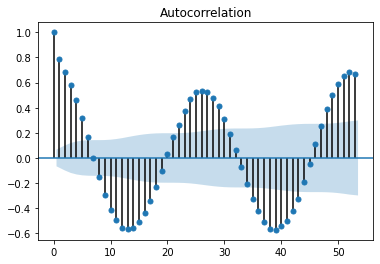

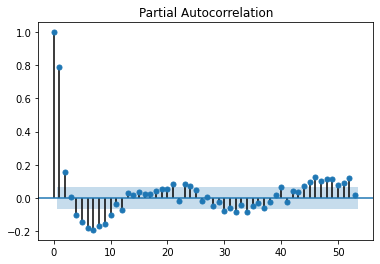

In [19]:
sm.graphics.tsa.plot_acf(data_energy_resampled_weeks['PJME_MW'].values, lags=53)
plt.show()
sm.graphics.tsa.plot_pacf(data_energy_resampled_weeks['PJME_MW'].values, lags=53)
plt.show()

ACF - для недельного ресемплинга - сезонность 52 недели(2-й по уровню максимум корреляции), по PACF - видна связь с 1-й по 12-ю недели (и повтор с 45 по 52-ю недели) Значения истории будем брать до 53-й недели

In [20]:
p = 53
for i in range(p):
    data_energy_resampled_weeks['t'+str(p-i)]=0
    data_energy_resampled_weeks['t'+str(p-i)].values[p:] = data_energy_resampled_weeks['PJME_MW'].values[i:-(p)+i]

In [22]:
first_diff =np.array(data_energy_resampled_weeks.iloc[1:,0].values - data_energy_resampled_weeks.iloc[:-1,0].values).astype('float32') 
data_energy_resampled_weeks['diff1'] = 0
data_energy_resampled_weeks['diff1'] =  data_energy_resampled_weeks['diff1'].astype('float') 
data_energy_resampled_weeks['diff1'].values[1:] = first_diff

k = 13
for i in range(k):
    data_energy_resampled_weeks['d'+str(k-i)]=0
    data_energy_resampled_weeks['d'+str(k-i)].values[k:] = data_energy_resampled_weeks['diff1'].values[i:-(k)+i]

Добавим сглаживание для поиска основных моделей изменения ряда

In [23]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [24]:
data_energy_resampled_weeks['exp_0_01'] = exponential_smoothing(data_energy_resampled_weeks['PJME_MW'], 0.01)
data_energy_resampled_weeks['exp_0_03'] = exponential_smoothing(data_energy_resampled_weeks['PJME_MW'], 0.03)
data_energy_resampled_weeks['exp_0_04'] = exponential_smoothing(data_energy_resampled_weeks['PJME_MW'], 0.04)
data_energy_resampled_weeks['exp_0_06'] = exponential_smoothing(data_energy_resampled_weeks['PJME_MW'], 0.06)
data_energy_resampled_weeks['exp_0_07'] = exponential_smoothing(data_energy_resampled_weeks['PJME_MW'], 0.07)
data_energy_resampled_weeks['exp_0_08'] = exponential_smoothing(data_energy_resampled_weeks['PJME_MW'], 0.08)

### Горизонт прогнозирования h = 1

Запишем итоговую систему признаков и проведем ее анализ. 

Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)

In [25]:
from sklearn.preprocessing import StandardScaler

# Целевой признак
scl_target=StandardScaler() 

# p = 53
h = 1

target = data_energy_resampled_weeks['PJME_MW'].values[h+p:].reshape((data_energy_resampled_weeks.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(812, 1)

In [26]:
# Входные признаки

scl_x=StandardScaler() 

X = data_energy_resampled_weeks.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(812, 80)

In [27]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)

sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(812, 5)

In [28]:
column_names = data_energy_resampled_weeks.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'pca2', 't52', 't51', 't50'], dtype='object')

In [29]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(812, 8)

In [30]:
column_namesp = data_energy_resampled_weeks.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'pca2', 't53', 't52', 't51', 't50', 't49', 't1'], dtype='object')

In [31]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=500).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(812, 5)

In [32]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0  6  8  9 10]
Номера признаков лучших признаков по процентной форме:  [ 0  6  7  8  9 10 11 59]
Номера признаков для выбора по модели :  [ 0  8  9 11 24]


Выбираем признаки по всем методам сразу

In [33]:
list_param = [ 0 , 6,  7, 8,  9, 10, 11, 24, 59]
X_new = X[:,list_param]
data_energy_resampled_weeks.columns[list_param]

Index(['PJME_MW', 'pca2', 't53', 't52', 't51', 't50', 't49', 't36', 't1'], dtype='object')

### Строим модель для предсказания

In [34]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


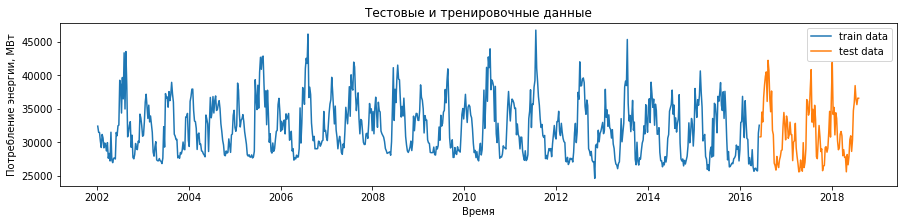

In [35]:
train, test = split_data( data_energy_resampled_weeks, '06-06-2016')

plt.figure( figsize=( 15, 3 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [36]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Параметры модели подбираем по RandomizedSearchCV (max_depth=3,n_estimators=100)

In [38]:
model_g = GradientBoostingRegressor(max_depth=3, random_state=40, n_estimators=100)
model_l = LinearRegression()

In [39]:
model_g.fit( X_train, y_train )
model_l.fit( X_train, y_train )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [40]:
y_test_pred_g = model_g.predict(X_test)
y_test_pred_l = model_l.predict(X_test)

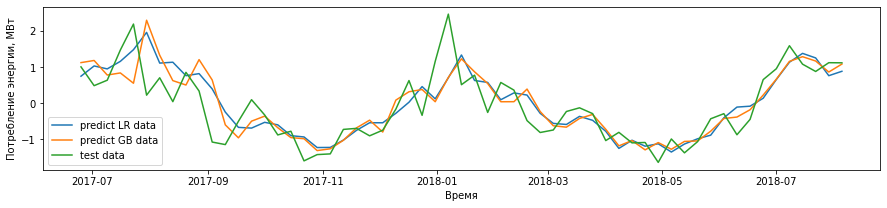

In [41]:
plt.figure( figsize=( 15, 3 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_l, label='predict LR data' )
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
er_l = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_l))
print('ошибка LR MAPE :  ', er_l,'%')

ошибка градиентного бустинга MAPE :   5.730459946149543 %
ошибка LR MAPE :   5.722683538018268 %


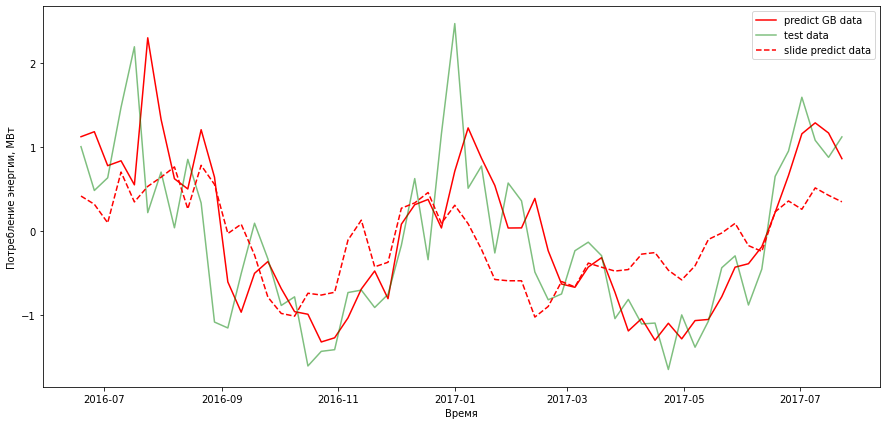

In [44]:
#['PJME_MW', 't53', 't52', 't51', 't50', 't49', 't38', 't36', 't1']
# [ 0 , 7,  8,  9, 10, 11, 22, 24, 59]
X_test_100 = X_test.copy()
X_test_100 = np.vstack([X_train[-p-h:,:],X_test_100])
y_test_100 = y_test_pred_g.copy()
y_test_100 = np.hstack([y_train[-p-h:],y_test_100])
N10 = 58
for ip in range(N10):
    i=ip+p 
    # делаю отступ р для использования данных на первом шаге рекурсии
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape((1,9)))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    X_test_100[i+1,1] = X_test_100[i-53+1,0]
    X_test_100[i+1,2] = X_test_100[i-52+1,0]
    X_test_100[i+1,3] = X_test_100[i-51+1,0]
    X_test_100[i+1,4] = X_test_100[i-50+1,0]
    X_test_100[i+1,5] = X_test_100[i-49+1,0]
    X_test_100[i+1,6] = X_test_100[i-38+1,0]
    X_test_100[i+1,7] = X_test_100[i-56+1,0]
    X_test_100[i+1,8] = X_test_100[i-1+1,0]

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[p:N10+p], '--r',label='slide predict data')

plt.legend()
plt.show()            

In [45]:
er_100 = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_100[p+1:]))
print('ошибка LR MAPE :  ', er_100,'%')

ошибка LR MAPE :   8.008107822984774 %


In [46]:
for j in [0,10,20,30,40]:
    er_100j = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[j:j+10]),y_pred = scl_target.inverse_transform( y_test_100[p+1+j:j+10+p+1]))

    print('ошибка рекурсивной модели на отрезке',j,':',j+10,'  MAPE :  ', er_100j,'%')

ошибка рекурсивной модели на отрезке 0 : 10   MAPE :   5.283217155410481 %
ошибка рекурсивной модели на отрезке 10 : 20   MAPE :   10.066418406066177 %
ошибка рекурсивной модели на отрезке 20 : 30   MAPE :   9.126061059992304 %
ошибка рекурсивной модели на отрезке 30 : 40   MAPE :   6.690526850074977 %
ошибка рекурсивной модели на отрезке 40 : 50   MAPE :   10.449849179770213 %


Чем дальше, тем хуже работает модель. И на первом отрезке почему-то было неплохо.

### Горизонт h=4

In [47]:
h = 4

# целевой признак
scl_target=StandardScaler() 
target = data_energy_resampled_weeks['PJME_MW'].values[h+p:].reshape((data_energy_resampled_weeks.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

# Входные признаки

scl_x=StandardScaler() 
X = data_energy_resampled_weeks.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

sfp=SelectPercentile(f_regression, percentile=12)
X_new2 = sfp.fit_transform(X, y.ravel())

list_param =np.where(sfp.get_support())[0]
list_param 

array([10, 11, 12, 13, 14, 24, 25, 26, 51, 52])

Признаки другие . при h=1 использовали другие.

In [48]:
X_new = X[:,list_param]
data_energy_resampled_weeks.columns[list_param]

Index(['t50', 't49', 't48', 't47', 't46', 't36', 't35', 't34', 't9', 't8'], dtype='object')

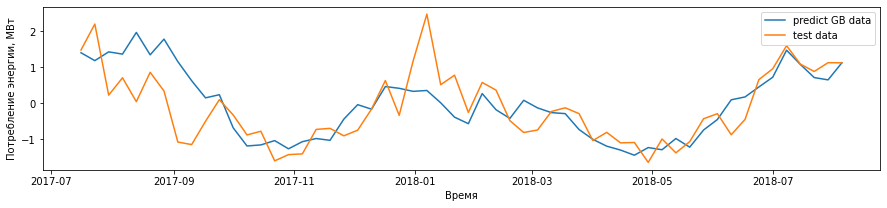

ошибка градиентного бустинга MAPE :   6.762805785887693 %


In [49]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

model_g = GradientBoostingRegressor(max_depth=3, random_state=40, n_estimators=100)
model_g.fit( X_train, y_train )

y_test_pred_g = model_g.predict(X_test)

plt.figure( figsize=( 15, 3 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')

plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

Оценим результаты:
Модель h=1 - лучший результат 5.7%

Рекурсивная модель - 6%

Модель h=4 - лучший результат 6.7 %
Все модели сделали ошибку на участке 2017-07:2017-10